# 4-qubit VQE with cuPauliProp (numerical gradients)
Simple VQE demo minimizing $Z_0$ expectation for 4 qubits system. Here I didn't apply my easy module, so this is the exemplary code using **cuQuantum-python-low-level-binding**
- Heisenberg Pauli propagation using cuQuantum cuPauliProp
- Estimate gradients with Central Difference method


## Pauli Propagation Protocol

In [13]:
# Imports
import numpy as np
import cupy as cp
from cuquantum.bindings import cupauliprop as cupp
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import contextlib

# Global config
NUM_QUBITS = 12
NUM_LAYERS = 3
PI = np.pi

cp.random.seed(42)
np.random.seed(42)

# Observable: Z_0 + Z_1 (Linear Combination of Pauli strings)
OBS_TERMS = [
    (1.0,  0b0000000000, 0b0000000001),  # Z_0: coef=1.0, X_mask=0, Z_mask=1
    (1.0,  0b0000000000, 0b0000000010),  # Z_1: coef=1.0, X_mask=0, Z_mask=2
]

# OBS_TERMS = [
#     # coef,   X_mask (bin),    Z_mask (bin)      # Pauli string 설명
#     ( 0.8,    0b0000000101,    0b0000000010),    # X0 X2 Z1
#     (-0.6,    0b0000010000,    0b0000001000),    # X4 Z3
#     ( 0.5,    0b0000000000,    0b0000010011),    # Z0 Z1 Z4
#     ( 0.4,    0b0000001100,    0b0000001100),    # Y2 Y3  (X=1,Z=1 → Y)
#     (-0.3,    0b0001000000,    0b0000100000),    # X6 Z5
#     ( 0.9,    0b0100000000,    0b1000000000),    # X9 Z8
# ]

In [14]:
# Helper: build circuit operators for given parameters
def build_circuit(handle, thetas):
    """Return list of gate operator handles for RY layers + CNOT chain.
    thetas shape: (NUM_LAYERS, NUM_QUBITS)
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    gates = []
    pauli_y = np.array([1], dtype=np.int32)  # Y
    # Layers: RY on all qubits, then CNOT chain (0-1-2-3)
    for layer in range(NUM_LAYERS):
        for q in range(NUM_QUBITS):
            for i in range(3):
                angle = thetas[layer, q, i]
                qubit_arr = np.array([q], dtype=np.int32)
                gates.append(
                    cupp.create_pauli_rotation_gate_operator(
                        handle, angle, 1, qubit_arr.ctypes.data, [i]
                    )
                )
        # simple entangler per layer
        for tgt, ctrl in [(0, 1), (1, 2), (2, 3)]:
            cnot_qubits = np.array([tgt, ctrl], dtype=np.int32)
            gates.append(
                cupp.create_clifford_gate_operator(
                    handle, 0,  # CX
                    cnot_qubits.ctypes.data
                )
            )
    return gates

# Helper: destroy all operators
def destroy_gates(gates):
    for g in gates:
        cupp.destroy_operator(g)


In [15]:
# Core: run Pauli propagation and return ⟨obs⟩ for |0...0⟩
def expectation_pauli(thetas, obs_terms=OBS_TERMS, max_terms=2048, stream=None):
    """
    Calculate expectation value ⟨0|U† O U|0⟩ where O is a linear combination of Pauli terms.
    Optionally binds computation to a given CuPy stream for parallel launches.

    Args:
        thetas: circuit parameters shape (NUM_LAYERS, NUM_QUBITS)
        obs_terms: list of (coef, X_mask, Z_mask) tuples defining observable
        max_terms: max Pauli terms buffer size
        stream: cp.cuda.Stream for non-blocking concurrent evaluations
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    stream_ctx = stream if stream is not None else contextlib.nullcontext()
    with stream_ctx:
        handle = cupp.create()
        num_packed_ints = cupp.get_num_packed_integers(NUM_QUBITS)

        
        ###### Allocate buffers, This is fixed part. Don't modify ######
        pauli_buf_size = 2 * num_packed_ints * max_terms
        coef_buf_size = max_terms
        d_input_pauli = cp.zeros(pauli_buf_size, dtype=cp.uint64)
        d_input_coef = cp.zeros(coef_buf_size, dtype=cp.float64)

        workspace_size = 8 * 1024 * 1024
        d_workspace = cp.cuda.alloc(workspace_size)
        workspace = cupp.create_workspace_descriptor(handle)
        cupp.workspace_set_memory(handle, workspace, 0, 0, d_workspace.ptr, workspace_size)
        #########################################################################

        ################### Making Initial Observable ###################
        pauli_list = []
        coef_list = []
        for c, xm, zm in obs_terms:
            pauli_list.extend([xm, zm])
            coef_list.append(c)
        
        
        d_input_pauli[:len(pauli_list)] = cp.array(pauli_list, dtype=cp.uint64)
        d_input_coef[:len(coef_list)] = cp.array(coef_list, dtype=cp.float64)
        ################################################################

        input_exp = cupp.create_pauli_expansion(
            handle,
            NUM_QUBITS,
            d_input_pauli.data.ptr,
            d_input_pauli.nbytes,
            d_input_coef.data.ptr,
            d_input_coef.nbytes,
            1,  # CUDA_R_64F
            len(coef_list),  # num_terms of Initial observable
            1,
            1,
        )

        d_output_pauli = cp.zeros_like(d_input_pauli)
        d_output_coef = cp.zeros_like(d_input_coef)
        output_exp = cupp.create_pauli_expansion(
            handle,
            NUM_QUBITS,
            d_output_pauli.data.ptr,
            d_output_pauli.nbytes,
            d_output_coef.data.ptr,
            d_output_coef.nbytes,
            1,
            0,         # num_terms of final observable, to be filled
            0, 
            0,
        )


        ##### Build circuit gates #####
        gates = build_circuit(handle, thetas)


        ############### Apply gates in reverse order (Pauli Propagation starts!) ###############
        current_input = input_exp
        current_output = output_exp
        for gate in reversed(gates):
            num_terms = cupp.pauli_expansion_get_num_terms(handle, current_input)
            view = cupp.pauli_expansion_get_contiguous_range(handle, current_input, 0, num_terms) # view is a pointer to a part of pauli expansion


            cupp.pauli_expansion_view_compute_operator_application(
                handle,
                view,
                current_output,
                gate,
                1,  # adjoint
                0,
                0,
                0,
                None,
                workspace,
            )
            cupp.destroy_pauli_expansion_view(view)
            current_input, current_output = current_output, current_input
        #########################################################################################

        
        final_terms = cupp.pauli_expansion_get_num_terms(handle, current_input)
        final_view = cupp.pauli_expansion_get_contiguous_range(handle, current_input, 0, final_terms)
        result = np.array([0.0], dtype=np.float64)       # To hold the expectation value
        cupp.pauli_expansion_view_compute_trace_with_zero_state(
            handle,
            final_view,
            result.ctypes.data,
            workspace,
        )
        expectation = float(result[0])

        # Cleanup for next run
        cupp.destroy_pauli_expansion_view(final_view)
        destroy_gates(gates)
        cupp.destroy_pauli_expansion(input_exp)
        cupp.destroy_pauli_expansion(output_exp)
        cupp.destroy_workspace_descriptor(workspace)
        cupp.destroy(handle)
    return expectation

## VQE example with several gradient methods  
Our observable looks like
$$0.8·X₀X₂Z₁ -0.6·X₄Z₃ +0.5·Z₀Z₁Z₄ +0.4·Y₂Y₃ -0.3·X₆Z₅ +0.9·X₉Z₈$$

### Parameter-Shift of Pauli Propagation
It is exact method, but takes time resources linearly growing with the number of variational gate parameters

In [16]:
# Parameter-shift gradient (exact for Pauli rotations)
# shift = π/2 for RY-type generators with eigenvalues ±1/2
SHIFT = PI / 2

def parameter_shift(thetas, obs_terms=OBS_TERMS, shift=SHIFT, use_parallel=True):
    """
    Parameter-shift gradient. When use_parallel=True, launch per-parameter
    evaluations concurrently.
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    grads = np.zeros_like(thetas)
    indices = list(np.ndindex(*thetas.shape))

    # Fallback to sequential if only one parameter or parallel disabled
    if (not use_parallel) or len(indices) == 1:
        for idx in indices:
            t_plus = thetas.copy(); t_plus[idx] += shift
            t_minus = thetas.copy(); t_minus[idx] -= shift
            f_plus = expectation_pauli(t_plus, obs_terms)
            f_minus = expectation_pauli(t_minus, obs_terms)
            grads[idx] = 0.5 * (f_plus - f_minus)
        return grads

    def worker(idx):
        t_plus = thetas.copy(); t_plus[idx] += shift
        t_minus = thetas.copy(); t_minus[idx] -= shift
        f_plus = expectation_pauli(t_plus, obs_terms)
        f_minus = expectation_pauli(t_minus, obs_terms)
        return idx, 0.5 * (f_plus - f_minus)

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(worker, idx) for idx in indices]
        for fut in futures:
            idx, val = fut.result()
            grads[idx] = val
    return grads

In [17]:
# Simple gradient descent on expectation ⟨Z_0 + Z_1⟩ using parameter shift
init_thetas = (np.random.rand(NUM_LAYERS, NUM_QUBITS, 3) - 0.5) * 0.2
lr = 0.4
steps = 30
history = []

print('Observable')
print('Initial parameters:\n', init_thetas[0])
params = init_thetas.copy()
for step in range(steps):
    val = expectation_pauli(params, OBS_TERMS)
    history.append(val)
    grads = parameter_shift(params, obs_terms=OBS_TERMS)
    params -= lr * grads
    print(f"step {step:02d} | exp = {val:+.6f} | grad norm = {np.linalg.norm(grads):.4f}")

print("final exp:", expectation_pauli(params, OBS_TERMS))
print('Final parameters:\n', params[0])

Observable
Initial parameters:
 [[-0.02509198  0.09014286  0.04639879]
 [ 0.0197317  -0.06879627 -0.0688011 ]
 [-0.08838328  0.07323523  0.020223  ]
 [ 0.04161452 -0.0958831   0.09398197]
 [ 0.06648853 -0.05753218 -0.06363501]
 [-0.0633191  -0.03915155  0.00495129]
 [-0.013611   -0.04175417  0.02237058]
 [-0.07210123 -0.04157107 -0.02672763]
 [-0.008786    0.05703519 -0.06006524]
 [ 0.00284689  0.01848291 -0.09070992]
 [ 0.02150897 -0.06589518 -0.08698968]
 [ 0.08977711  0.09312641  0.06167947]]
step 00 | exp = +1.993306 | grad norm = 0.2001
step 01 | exp = +1.967771 | grad norm = 0.4376
step 02 | exp = +1.846824 | grad norm = 0.9388
step 03 | exp = +1.316163 | grad norm = 1.8362
step 04 | exp = -0.343080 | grad norm = 2.3815
step 05 | exp = -1.930962 | grad norm = 0.6303
step 06 | exp = -1.997611 | grad norm = 0.1163
step 07 | exp = -1.999875 | grad norm = 0.0251
step 08 | exp = -1.999990 | grad norm = 0.0062
step 09 | exp = -1.999999 | grad norm = 0.0019
step 10 | exp = -2.000000 | g

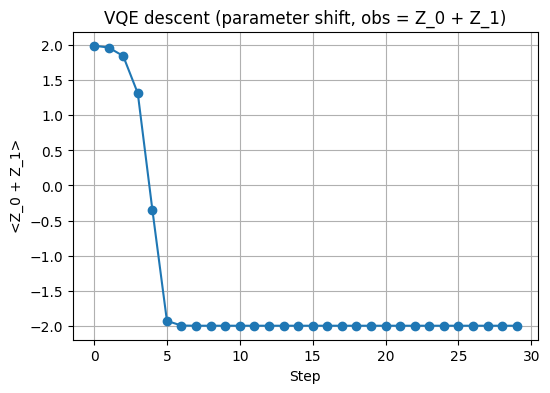

In [18]:
# Plot expectation value trajectory
plt.figure(figsize=(6, 4))
plt.plot(history, marker='o')
plt.xlabel('Step')
plt.ylabel('<Z_0 + Z_1>')
plt.title('VQE descent (parameter shift, obs = Z_0 + Z_1)')
plt.grid(True)
plt.show()

### Comparison with PennyLane
Speed comparison with PennyLane for same circuit

#### Parameter-Shift

In [19]:
# PennyLane 구현
import pennylane as qml
import time
import numpy as np
PI = np.pi

# NUM_QUBITS = 12
# NUM_LAYERS = 3
# init_thetas = (np.random.rand(NUM_LAYERS, NUM_QUBITS, 3) - 0.5) * 0.2

# PennyLane device choice (lightning.qubit = CPU, lightning.gpu = GPU)
dev = qml.device("lightning.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit_pennylane(params):
    """
    Same circuit structure: RY layers + CNOT chain
    params shape: (NUM_LAYERS, NUM_QUBITS, 3    )
    """
    # RY layers + CNOT entangler
    for layer in range(NUM_LAYERS):
        for q in range(NUM_QUBITS):
            qml.RX(params[layer, q, 0], wires=q)
            qml.RZ(params[layer, q, 1], wires=q)
            qml.RY(params[layer, q, 2], wires=q)
        # CNOT chain: 0-1-2-3 (반복)
        for q in range(NUM_QUBITS - 1):
            qml.CNOT(wires=[q, q + 1])

   
    # Observable: Z_0 + Z_1
    return qml.expval(qml.PauliZ(0) + qml.PauliZ(1))

# Use same initial parameters
init_params_pl = init_thetas.copy()

# Parameter shift gradient manual implementation (PennyLane native)
def grad_shift_pennylane(params, shift=PI / 2):
    """Parameter shift rule for PennyLane circuit"""
    grads = np.zeros_like(params)
    for idx in np.ndindex(*params.shape):
        params_plus = params.copy(); params_plus[idx] += shift
        params_minus = params.copy(); params_minus[idx] -= shift
        f_plus = circuit_pennylane(params_plus)
        f_minus = circuit_pennylane(params_minus)
        grads[idx] = 0.5 * (f_plus - f_minus)
    return grads

# VQE optimization (PennyLane)
print("\n" + "=" * 60)
print("PennyLane VQE optimization (same settings)")
print("=" * 60)

params_pl = init_params_pl.copy()
history_pl = []
lr_pl = 0.4
steps_pl = 30

start_time_pl = time.time()
for step in range(steps_pl):
    val = circuit_pennylane(params_pl)
    history_pl.append(val)
    grads = grad_shift_pennylane(params_pl)
    params_pl -= lr_pl * grads
    if step % 5 == 0 or step == steps_pl - 1:
        print(f"step {step:02d} | exp = {val:+.6f} | grad norm = {np.linalg.norm(grads):.4f}")

end_time_pl = time.time()
time_pl = end_time_pl - start_time_pl

print(f"\nFinal exp (PennyLane): {circuit_pennylane(params_pl):+.6f}")
print(f"Elapsed time (PennyLane): {time_pl:.2f} seconds")


PennyLane VQE optimization (same settings)
step 00 | exp = +1.977259 | grad norm = 0.2647
step 05 | exp = -0.244358 | grad norm = 1.8466
step 10 | exp = -1.939157 | grad norm = 0.6388
step 15 | exp = -1.310535 | grad norm = 2.5813
step 20 | exp = -1.399566 | grad norm = 2.2670
step 25 | exp = -1.851422 | grad norm = 1.1775
step 29 | exp = -1.956951 | grad norm = 0.6310

Final exp (PennyLane): -1.967872
Elapsed time (PennyLane): 42.40 seconds


### Compare optimization trajectory

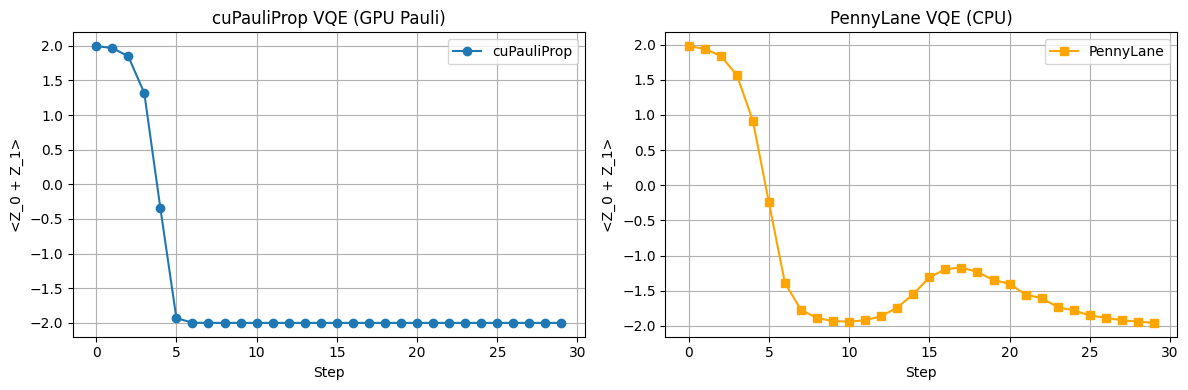


Final Expectation Value Comparison:
  cuPauliProp: -2.000000
  PennyLane:   -1.956951
  Difference:  0.043049


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# cuPauliProp
axes[0].plot(history, marker='o', label='cuPauliProp')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('<Z_0 + Z_1>')
axes[0].set_title('cuPauliProp VQE (GPU Pauli)')
axes[0].grid(True)
axes[0].legend()

# PennyLane 
axes[1].plot(history_pl, marker='s', label='PennyLane', color='orange')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('<Z_0 + Z_1>')
axes[1].set_title('PennyLane VQE (CPU)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# 최종 값 비교
print(f"\nFinal Expectation Value Comparison:")
print(f"  cuPauliProp: {history[-1]:+.6f}")
print(f"  PennyLane:   {history_pl[-1]:+.6f}")
print(f"  Difference:  {abs(history[-1] - history_pl[-1]):.6f}")

### GradientDescent in PennyLane

In [24]:
# NUM_QUBITS = 12
# NUM_LAYERS = 3
# init_thetas = (np.random.rand(NUM_LAYERS, NUM_QUBITS, 3) - 0.5) * 0.2

# PennyLane with gradient optimizers
import pennylane as qml
import time

# PennyLane 디바이스
dev = qml.device("lightning.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit_pennylane(params):
    """
    같은 구조의 회로: RY layers + CNOT chain
    params shape: (NUM_LAYERS, NUM_QUBITS)
    """
    for layer in range(NUM_LAYERS):
        for q in range(NUM_QUBITS):
            qml.RX(params[layer, q, 0], wires=q)
            qml.RZ(params[layer, q, 1], wires=q)
            qml.RY(params[layer, q, 2], wires=q)
        # CNOT chain
        for q in range(NUM_QUBITS - 1):
            qml.CNOT(wires=[q, q + 1])
    
    # Observable: Z_0 + Z_1
    return qml.expval(qml.PauliZ(0) + qml.PauliZ(1))

# 손실함수 (최소화)
def loss_fn(params):
    return circuit_pennylane(params)

# 같은 초기 파라미터 사용
init_params_pl = init_thetas.copy()
params_pl = init_params_pl.copy()

# PennyLane 옵티마이저 (GradientDescent 또는 Adam)
opt = qml.GradientDescentOptimizer(stepsize=0.4)
# opt = qml.AdamOptimizer(stepsize=0.4)  # 대안

# VQE 최적화 (PennyLane)
print("\n" + "=" * 60)
print("PennyLane VQE optimization (optimizer, automatic differentiation)")
print("=" * 60)

history_pl = []
steps_pl = 30

start_time_pl = time.time()
for step in range(steps_pl):
    params_pl, loss_val = opt.step_and_cost(loss_fn, params_pl)
    exp_val = -loss_val
    history_pl.append(exp_val)
    if step % 5 == 0 or step == steps_pl - 1:
        print(f"step {step:02d} | exp = {exp_val:+.6f}")

end_time_pl = time.time()
time_pl = end_time_pl - start_time_pl

print(f"\nFinal exp (PennyLane): {loss_fn(params_pl):+.6f}")
print(f"Time used (PennyLane): {time_pl:.2f} seconds")


PennyLane VQE optimization (optimizer, automatic differentiation)
step 00 | exp = -1.977259
step 05 | exp = -1.977259
step 10 | exp = -1.977259
step 15 | exp = -1.977259
step 20 | exp = -1.977259
step 25 | exp = -1.977259
step 29 | exp = -1.977259

Final exp (PennyLane): +1.977259
Time used (PennyLane): 0.20 seconds


### Stochastic Gradient (SPSA-style)
Instead of exact parameter shift that needs much time, Let's estimate stochastic gradient with only 2 trials

In [30]:
import time 

# Stochastic gradient estimation (SPSA-style)
def grad_stochastic(thetas, obs_terms=OBS_TERMS, shift=1e-5):
    """
    Stochastic gradient estimate using simultaneous perturbations.
    Only requires 2 function evaluations regardless of number of parameters.
    
    For each parameter, randomly choose δᵢ ∈ {-1, +1}, then:
      ∇f ≈ [f(θ + shift·δ) - f(θ - shift·δ)] / (2·shift) · δ
    
    This gives an unbiased but noisy gradient estimate.
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    
    # Random perturbation direction: each element is ±1
    delta = np.random.choice([-1, 1], size=thetas.shape)
    
    # Perturbed parameters
    theta_plus = thetas + shift * delta
    theta_minus = thetas - shift * delta
    
    # Function evaluations
    f_plus = expectation_pauli(theta_plus, obs_terms)
    f_minus = expectation_pauli(theta_minus, obs_terms)
    
    # Gradient estimate: [f(+) - f(-)] / (2·shift) · δ
    grad_estimate = ((f_plus - f_minus) / (2 * shift)) * delta
    
    return grad_estimate


# VQE with stochastic gradient
print("\n" + "=" * 60)
print("VQE with Stochastic Gradient (SPSA-style)")
print("=" * 60)

# 같은 초기 조건 사용
np.random.seed(42)
params_stoc = init_thetas.copy()

lr_stoc = 0.4
steps_stoc = 100
history_stoc = []

start_time_stoc = time.time()
for step in range(steps_stoc):
    val = expectation_pauli(params_stoc, OBS_TERMS)
    history_stoc.append(val)
    
    # Stochastic gradient (only 2 evaluations per step!)
    grads_stoc = grad_stochastic(params_stoc, obs_terms=OBS_TERMS, shift = 1e-6)
    params_stoc -= lr_stoc * grads_stoc
    
    if step % 20 == 0 or step == steps_stoc - 1:
        print(f"step {step:02d} | exp = {val:+.6f} | grad norm = {np.linalg.norm(grads_stoc):.4f}")

end_time_stoc = time.time()
time_stoc = end_time_stoc - start_time_stoc

print(f"\nFinal exp (Stochastic): {expectation_pauli(params_stoc, OBS_TERMS):+.6f}")
print(f"Time used (Stochastic): {time_stoc:.2f} seconds")
print(f"\nComparison:")
print(f"  Parameter-shift: 2 evaluations per parameter = {2 * np.prod(init_thetas.shape)} evaluations/step")
print(f"  Stochastic:      2 evaluations total = 2 evaluations/step")
print(f"  Speedup:         ~{np.prod(init_thetas.shape)}x faster")


VQE with Stochastic Gradient (SPSA-style)
step 00 | exp = +1.993306 | grad norm = 1.6961
step 20 | exp = -0.204840 | grad norm = 18.0234
step 40 | exp = -0.716768 | grad norm = 14.7506
step 60 | exp = -1.030650 | grad norm = 43.4186
step 80 | exp = -1.394620 | grad norm = 11.6628
step 99 | exp = -1.257077 | grad norm = 11.6099

Final exp (Stochastic): -0.959204
Time used (Stochastic): 2.53 seconds

Comparison:
  Parameter-shift: 2 evaluations per parameter = 216 evaluations/step
  Stochastic:      2 evaluations total = 2 evaluations/step
  Speedup:         ~108x faster


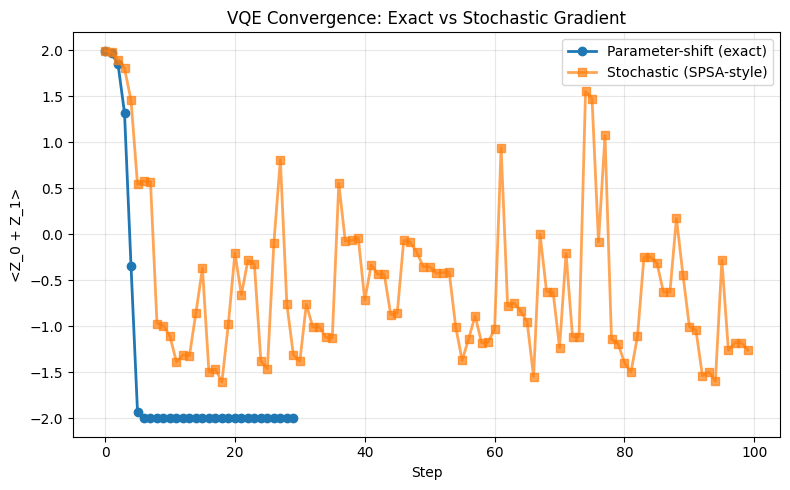


Final results comparison:
  Parameter-shift: -2.000000
  Stochastic:      -1.257077
  Difference:      0.742923


In [32]:
# VQE Convergence Comparison: Parameter-shift vs Stochastic
plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', label='Parameter-shift (exact)', linewidth=2)
plt.plot(history_stoc, marker='s', alpha=0.7, label='Stochastic (SPSA-style)', linewidth=2)
plt.xlabel('Step')
plt.ylabel('<Z_0 + Z_1>')
plt.title('VQE Convergence: Exact vs Stochastic Gradient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFinal results comparison:")
print(f"  Parameter-shift: {history[-1]:+.6f}")
print(f"  Stochastic:      {history_stoc[-1]:+.6f}")
print(f"  Difference:      {abs(history[-1] - history_stoc[-1]):.6f}")

As you can see, SPSA style lacks accuracy and pertubes lot. Can we improve this?

### Somwhere between Parameter-Shift and SPSA  
* K-SPSA
* Coordinate

SPSA is fast but inaccurate, and Parameter-shift is accurate, but slow. 

In [36]:
# Method 1: K-SPSA (Multiple random directions averaging)
# do average after k independent random perturbations
def grad_k_spsa(thetas, obs_terms=OBS_TERMS, shift=1e-5 / 2, k=5):
    """
    K-SPSA: Average gradient estimates from k independent random perturbations.
    Reduces variance compared to single SPSA while using only 2k evaluations.
    
    Args:
        k: number of random directions to average (k=1 → SPSA, k=p → full shift)
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    grad_sum = np.zeros_like(thetas)
    
    for _ in range(k):
        # Random perturbation direction
        delta = np.random.choice([-1, 1], size=thetas.shape)
        
        # Evaluate at perturbed points
        f_plus = expectation_pauli(thetas + shift * delta, obs_terms)
        f_minus = expectation_pauli(thetas - shift * delta, obs_terms)
        
        # Accumulate gradient estimate
        grad_sum += ((f_plus - f_minus) / (2 * shift)) * delta
    
    # Average over k samples
    return grad_sum / k


# Method 2: Coordinate Sampling (random subset parameter-shift)
# Select parts of parameters for exact gradient calculation
def grad_coordinate_sampling(thetas, obs_terms=OBS_TERMS, shift=np.pi/2, sample_fraction=0.1):
    """
    Coordinate sampling: randomly select subset of parameters for exact gradient.
    Remaining coordinates use zero gradient (no update).
    
    Args:
        sample_fraction: fraction of parameters to compute gradient for (0.0 to 1.0)
    """
    thetas = np.asarray(thetas, dtype=np.float64)
    grads = np.zeros_like(thetas)
    
    # Randomly select coordinates to compute gradient
    total_params = np.prod(thetas.shape)
    n_samples = max(1, int(total_params * sample_fraction))
    
    # Flatten for sampling, then reshape
    flat_indices = np.random.choice(total_params, size=n_samples, replace=False)
    
    for flat_idx in flat_indices:
        # Convert flat index to multi-dimensional index
        idx = np.unravel_index(flat_idx, thetas.shape)
        
        # Parameter-shift for this coordinate
        t_plus = thetas.copy(); t_plus[idx] += shift
        t_minus = thetas.copy(); t_minus[idx] -= shift
        f_plus = expectation_pauli(t_plus, obs_terms)
        f_minus = expectation_pauli(t_minus, obs_terms)
        grads[idx] = 0.5 * (f_plus - f_minus)
    
    return grads

k = 5
fraction = 0.1
print("\n" + "=" * 60)
print("Hybrid Gradient Methods")
print("=" * 60)
print(f"Total parameters: {np.prod(init_thetas.shape)}")
print(f"\nMethod 1: K-SPSA with k={k}")
print(f"  Evaluations per step: {2 * k} = {2 * k}")
print(f"\nMethod 2: Coordinate Sampling with {int(fraction * 100)}% parameters")
print(f"  Evaluations per step: {2 * int(fraction * np.prod(init_thetas.shape))}")
print("=" * 60)


Hybrid Gradient Methods
Total parameters: 108

Method 1: K-SPSA with k=5
  Evaluations per step: 10 = 10

Method 2: Coordinate Sampling with 10% parameters
  Evaluations per step: 20


In [37]:
# Test K-SPSA with k=5
np.random.seed(42)
params_kspsa = init_thetas.copy()
history_kspsa = []
lr_kspsa = 0.4
steps_kspsa = 100
k_samples = 5
SHIFT = 1e-4

print(f"\nRunning K-SPSA (k={k_samples})...")
start_time = time.time()
for step in range(steps_kspsa):
    val = expectation_pauli(params_kspsa, OBS_TERMS)
    history_kspsa.append(val)
    grads = grad_k_spsa(params_kspsa, obs_terms=OBS_TERMS, shift=SHIFT, k=k_samples)
    params_kspsa -= lr_kspsa * grads
    if step % 20 == 0 or step == steps_kspsa - 1:
        print(f"  step {step:03d} | exp = {val:+.6f}")
time_kspsa = time.time() - start_time
print(f"  Final result: {expectation_pauli(params_kspsa, OBS_TERMS):+.6f} ({time_kspsa:.2f} seconds)")


# Test Coordinate Sampling with 10% parameters
np.random.seed(42)
params_coord = init_thetas.copy()
history_coord = []
lr_coord = 0.4
steps_coord = 100
sample_frac = 0.1

print(f"\nRunning Coordinate Sampling ({int(sample_frac*100)}% parameters)...")
start_time = time.time()
for step in range(steps_coord):
    val = expectation_pauli(params_coord, OBS_TERMS)
    history_coord.append(val)
    grads = grad_coordinate_sampling(params_coord, obs_terms=OBS_TERMS, sample_fraction=sample_frac)
    params_coord -= lr_coord * grads
    if step % 20 == 0 or step == steps_coord - 1:
        print(f"  step {step:03d} | exp = {val:+.6f}")
time_coord = time.time() - start_time
print(f"  Final result: {expectation_pauli(params_coord, OBS_TERMS):+.6f} ({time_coord:.2f} seconds)")


Running K-SPSA (k=5)...
  step 000 | exp = +1.993306
  step 020 | exp = -1.999346
  step 040 | exp = -2.000000
  step 060 | exp = -2.000000
  step 080 | exp = -2.000000
  step 099 | exp = -2.000000
  Final result: -2.000000 (9.46 seconds)

Running Coordinate Sampling (10% parameters)...
  step 000 | exp = +1.993306
  step 020 | exp = +1.186282
  step 040 | exp = -0.618764
  step 060 | exp = -1.956965
  step 080 | exp = -1.984274
  step 099 | exp = -1.999757
  Final result: -1.999759 (18.48 seconds)


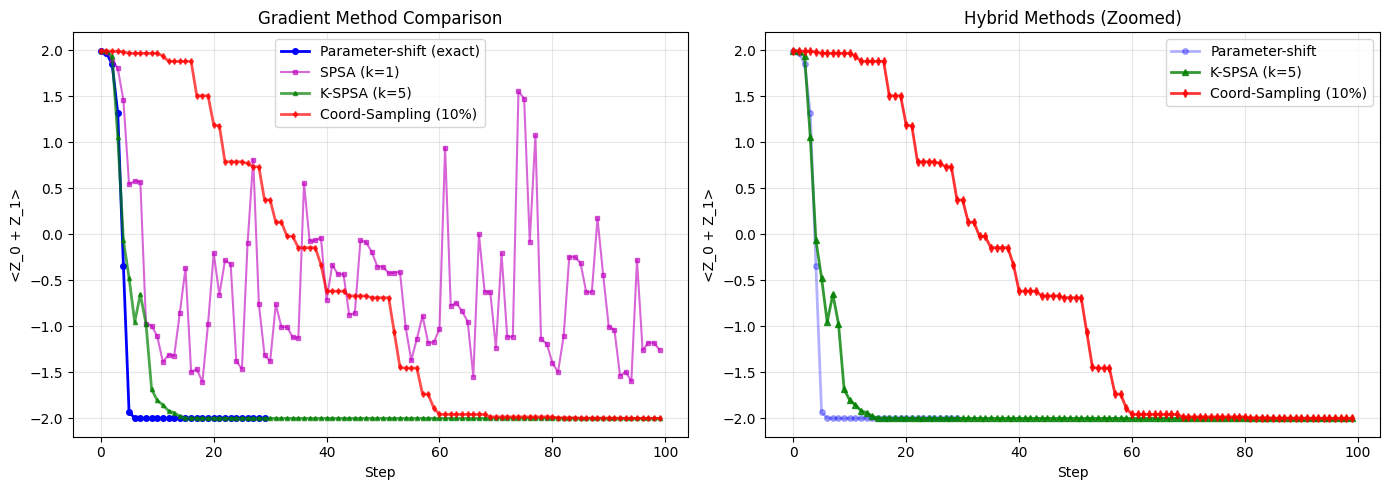


Final Results Summary
Method                     Final Value   Evals/step Relative Speed
----------------------------------------------------------------------
Parameter-shift              -2.000000          216         1x
SPSA (k=1)                   -1.257077            2       108x
K-SPSA (k=5)                 -2.000000           10        21x
Coord-Sampling (10%)         -1.999757           20        10x


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full comparison
ax = axes[0]
ax.plot(history[:100], marker='o', c = 'b', label='Parameter-shift (exact)', linewidth=2, markersize=4)
ax.plot(history_stoc[:100], marker='s', c = 'm', alpha=0.6, label='SPSA (k=1)', linewidth=1.5, markersize=3)
ax.plot(history_kspsa, marker='^', c = 'g', alpha=0.7, label=f'K-SPSA (k={k_samples})', linewidth=2, markersize=3)
ax.plot(history_coord, marker='d', c = 'r', alpha=0.7, label=f'Coord-Sampling ({int(sample_frac*100)}%)', linewidth=2, markersize=3)
ax.set_xlabel('Step')
ax.set_ylabel('<Z_0 + Z_1>')
ax.set_title('Gradient Method Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Zoom on hybrid methods
ax = axes[1]
ax.plot(history[:100], marker='o', c = 'b', label='Parameter-shift', linewidth=2, markersize=4, alpha=0.3)
ax.plot(history_kspsa, marker='^', c = 'g', alpha=0.8, label=f'K-SPSA (k={k_samples})', linewidth=2, markersize=4)
ax.plot(history_coord, marker='d', c = 'r', alpha=0.8, label=f'Coord-Sampling ({int(sample_frac*100)}%)', linewidth=2, markersize=4)
ax.set_xlabel('Step')
ax.set_ylabel('<Z_0 + Z_1>')
ax.set_title('Hybrid Methods (Zoomed)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final results comparison
print("\n" + "=" * 70)
print("Final Results Summary")
print("=" * 70)
print(f"{'Method':<25} {'Final Value':>12} {'Evals/step':>12} {'Relative Speed':>10}")
print("-" * 70)
n_params = np.prod(init_thetas.shape)
print(f"{'Parameter-shift':<25} {history[min(99, len(history)-1)]:>+12.6f} {2*n_params:>12} {'1x':>10}")
print(f"{'SPSA (k=1)':<25} {history_stoc[99]:>+12.6f} {2:>12} {f'{n_params}x':>10}")
print(f"{'K-SPSA (k=5)':<25} {history_kspsa[-1]:>+12.6f} {2*k_samples:>12} {f'{n_params//k_samples}x':>10}")
print(f"{'Coord-Sampling (10%)':<25} {history_coord[-1]:>+12.6f} {2*int(n_params*sample_frac):>12} {f'{1/sample_frac:.0f}x':>10}")
print("=" * 70)

## Comparison for 18 qubit system

In [4]:
import pennylane.numpy as pnp
import numpy as np
NUM_QUBITS = 18
NUM_LAYERS = 3
temp = (np.random.rand(NUM_LAYERS, NUM_QUBITS, 3) - 0.5) * 0.2
# PennyLane 구현 (옵티마이저 사용)
import pennylane as qml
import time

# PennyLane 디바이스
dev = qml.device("lightning.qubit", wires=NUM_QUBITS)

BIT_OBS_TERMS = [
    (0.8,  0b0000000101, 0b0000000010),  # X0 X2 Z1
    (-0.6, 0b0000010000, 0b0000001000),  # X4 Z3
    (0.5,  0b0000000000, 0b0000010011),  # Z0 Z1 Z4
    (0.4,  0b0000001100, 0b0000001100),  # Y2 Y3 (X=1,Z=1 -> Y)
    (-0.3, 0b0001000000, 0b0000100000),  # X6 Z5
    (0.9,  0b0100000000, 0b1000000000),  # X9 Z8
]

def masks_to_op(xmask, zmask):
    ops = []
    for q in range(NUM_QUBITS):
        x = (xmask >> q) & 1
        z = (zmask >> q) & 1
        if x and z:
            ops.append(qml.PauliY(q))
        elif x:
            ops.append(qml.PauliX(q))
        elif z:
            ops.append(qml.PauliZ(q))
    if not ops:
        return qml.Identity(0)
    return qml.prod(*ops)

# Build PennyLane Hamiltonian from the bitmask list
coeffs = []
ops = []
for c, xm, zm in BIT_OBS_TERMS:
    coeffs.append(c)
    ops.append(masks_to_op(xm, zm))
OBS_PENN = qml.Hamiltonian(coeffs, ops)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_pennylane(params):
    # Same RX/RZ/RY + CNOT chain as before
    for layer in range(NUM_LAYERS):
        for q in range(NUM_QUBITS):
            qml.RX(params[layer, q, 0], wires=q)
            qml.RZ(params[layer, q, 1], wires=q)
            qml.RY(params[layer, q, 2], wires=q)
        for q in range(NUM_QUBITS - 1):
            qml.CNOT(wires=[q, q + 1])
    return qml.expval(OBS_PENN)

# 손실함수 (기댓값 최소화)
def loss_fn(params):
    return circuit_pennylane(params)

# 같은 초기 파라미터 사용
init_params_pl = temp.copy()
params_pl = pnp.array(init_params_pl, requires_grad=True)

# PennyLane 옵티마이저 (GradientDescent 또는 Adam)
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# VQE 최적화 (PennyLane)
print("\n" + "=" * 60)
print("PennyLane VQE 최적화 (옵티마이저, 자동 미분)")
print("=" * 60)

history_pl = []
steps_pl = 50

start_time_pl = time.time()
for step in range(steps_pl):
    params_pl, loss_val = opt.step_and_cost(loss_fn, params_pl)
    exp_val = loss_val  # loss = expectation (we minimize)
    history_pl.append(exp_val)
    if step % 5 == 0 or step == steps_pl - 1:
        print(f"step {step:02d} | exp = {exp_val:+.6f}")

end_time_pl = time.time()
time_pl = end_time_pl - start_time_pl

final_exp = loss_fn(params_pl)
print(f"\n최종 exp (PennyLane): {final_exp:+.6f}")
print(f"소요 시간 (PennyLane): {time_pl:.2f}초)" )


PennyLane VQE 최적화 (옵티마이저, 자동 미분)
step 00 | exp = +0.475565
step 05 | exp = -0.005219
step 10 | exp = -1.456047
step 15 | exp = -2.476085
step 20 | exp = -2.597287
step 25 | exp = -2.613315
step 30 | exp = -2.619373
step 35 | exp = -2.624038
step 40 | exp = -2.623147
step 45 | exp = -2.571623
step 49 | exp = -2.434046

최종 exp (PennyLane): -2.400543
소요 시간 (PennyLane): 601.58초)


In [ ]:
# Test K-SPSA with k=5
np.random.seed(42)
params_kspsa = temp.copy()
history_kspsa = []
lr_kspsa = 0.4
steps_kspsa = 100
k_samples = 10
SHIFT = 1e-5

print(f"\nRunning K-SPSA (k={k_samples})...")
start_time = time.time()
for step in range(steps_kspsa):
    val = expectation_pauli(params_kspsa, OBS_TERMS)
    history_kspsa.append(val)
    grads = grad_k_spsa(params_kspsa, obs_terms=OBS_TERMS, shift=SHIFT, k=k_samples)
    params_kspsa -= lr_kspsa * grads
    if step % 20 == 0 or step == steps_kspsa - 1:
        print(f"  step {step:03d} | exp = {val:+.6f}")
time_kspsa = time.time() - start_time
print(f"  최종: {expectation_pauli(params_kspsa, OBS_TERMS):+.6f} ({time_kspsa:.2f}초)")



Running K-SPSA (k=10)...
  step 000 | exp = -0.021026
  step 020 | exp = -2.267363
  step 040 | exp = -2.465972
  step 060 | exp = -2.840929
  step 080 | exp = -2.844330
  step 099 | exp = -3.219213
  최종: -3.232132 (25.73초)


In [51]:
history_coord = []
lr_coord = 0.4
steps_coord = 160
sample_frac = 0.2
params_coord = temp.copy()

print(f"\nRunning Coordinate Sampling ({int(sample_frac*100)}% parameters)...")
start_time = time.time()
for step in range(steps_coord):
    val = expectation_pauli(params_coord, OBS_TERMS)
    history_coord.append(val)
    grads = grad_coordinate_sampling(params_coord, obs_terms=OBS_TERMS, sample_fraction=sample_frac)
    params_coord -= lr_coord * grads
    if step % 20 == 0 or step == steps_coord - 1:
        print(f"  step {step:03d} | exp = {val:+.6f}")
time_coord = time.time() - start_time
print(f"  최종: {expectation_pauli(params_coord, OBS_TERMS):+.6f} ({time_coord:.2f}초)")


Running Coordinate Sampling (20% parameters)...
  step 000 | exp = -0.021026
  step 020 | exp = -1.231306
  step 040 | exp = -1.933758
  step 060 | exp = -2.095303
  step 080 | exp = -2.195807
  step 100 | exp = -2.274590
  step 120 | exp = -2.337629
  step 140 | exp = -2.399965
  step 159 | exp = -2.417061
  최종: -2.417074 (126.41초)


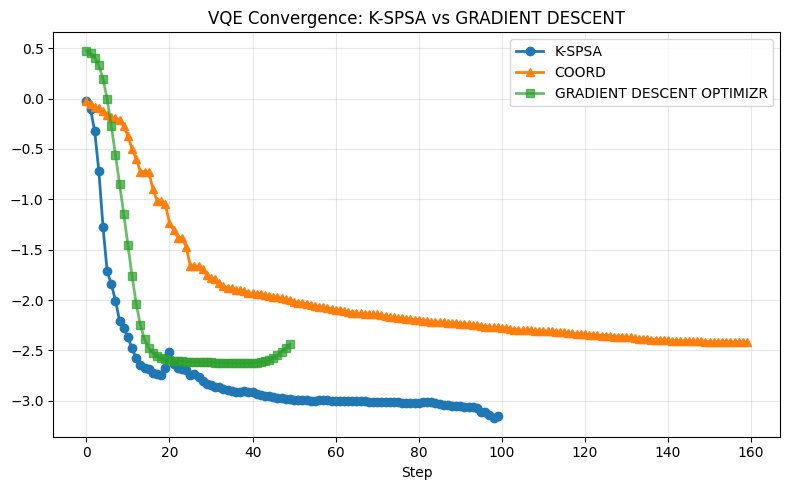


최종 결과 비교:
  K-SPSA: -3.149773
  COORD (10%):      -2.417061
  GRADIENT DESCENT:      -2.434046
  time:
      K-SPSA:          25.73s      COORD (10%):     41.06s      GRAIENT DESCENT: 601.58s


In [57]:
# 수렴 비교: Parameter-shift vs Stochastic
plt.figure(figsize=(8, 5))
plt.plot(history_kspsa, marker='o', label='K-SPSA', linewidth=2)
plt.plot(history_coord, marker='^', label='COORD', linewidth=2)
plt.plot(history_pl, marker='s', alpha=0.7, label='GRADIENT DESCENT OPTIMIZR', linewidth=2)
plt.xlabel('Step')

plt.title('VQE Convergence: K-SPSA vs GRADIENT DESCENT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n최종 결과 비교:")
print(f"  K-SPSA: {history_kspsa[-1]:+.6f}")
print(f"  COORD (10%):      {history_coord[-1]:+.6f}")
print(f"  GRADIENT DESCENT:      {history_pl[-1]:+.6f}")
# print(f"  차이:            {abs(history_kspsa[-1] - history_pl[-1]):.6f}")
print(f"  time:\n\
      K-SPSA:          25.73s\
      COORD (10%):     41.06s\
      GRAIENT DESCENT: 601.58s")

## K-dependence of K-SPSA


In [37]:
import time
# Test K-SPSA with k=5
k_samples = [1,3, 5, 10, 20]
np.random.seed(42)
params_kspsa = temp.copy()
history_kspsa = []
lr_kspsa = 0.4
steps_kspsa = 100
t = []
for k in k_samples:

    params_kspsa = temp.copy()
    history = []

    print(f"\nRunning K-SPSA (k={k})...")
    start_time = time.time()
    for step in range(steps_kspsa):
        val = expectation_pauli(params_kspsa, OBS_TERMS)
        history.append(val)
        grads = grad_k_spsa(params_kspsa, obs_terms=OBS_TERMS, k=k)
        params_kspsa -= lr_kspsa * grads
        if step % 20 == 0 or step == steps_kspsa - 1:
            print(f"k = {k}:  step {step:03d} | exp = {val:+.6f}")
    
    history_kspsa.append(history)
    t.append(time.time() - start_time)




Running K-SPSA (k=1)...
k = 1:  step 000 | exp = -0.021026
k = 1:  step 020 | exp = -0.321734
k = 1:  step 040 | exp = +0.530430
k = 1:  step 060 | exp = -0.594905
k = 1:  step 080 | exp = +0.034050
k = 1:  step 099 | exp = -0.430386

Running K-SPSA (k=3)...
k = 3:  step 000 | exp = -0.021026
k = 3:  step 020 | exp = -1.083447
k = 3:  step 040 | exp = -1.642552
k = 3:  step 060 | exp = -1.417402
k = 3:  step 080 | exp = -1.501430
k = 3:  step 099 | exp = -1.192540

Running K-SPSA (k=5)...
k = 5:  step 000 | exp = -0.021026
k = 5:  step 020 | exp = -1.975937
k = 5:  step 040 | exp = -1.027703
k = 5:  step 060 | exp = -2.187197
k = 5:  step 080 | exp = -2.520407
k = 5:  step 099 | exp = -1.723544

Running K-SPSA (k=10)...
k = 10:  step 000 | exp = -0.021026
k = 10:  step 020 | exp = -2.512697
k = 10:  step 040 | exp = -2.914998
k = 10:  step 060 | exp = -2.998013
k = 10:  step 080 | exp = -3.020055
k = 10:  step 099 | exp = -3.149773

Running K-SPSA (k=20)...
k = 20:  step 000 | exp = -

total parameters: 162
time for k=1: 3.86s
time for k=3: 8.17s
time for k=5: 14.60s
time for k=10: 26.31s
time for k=20: 50.96s


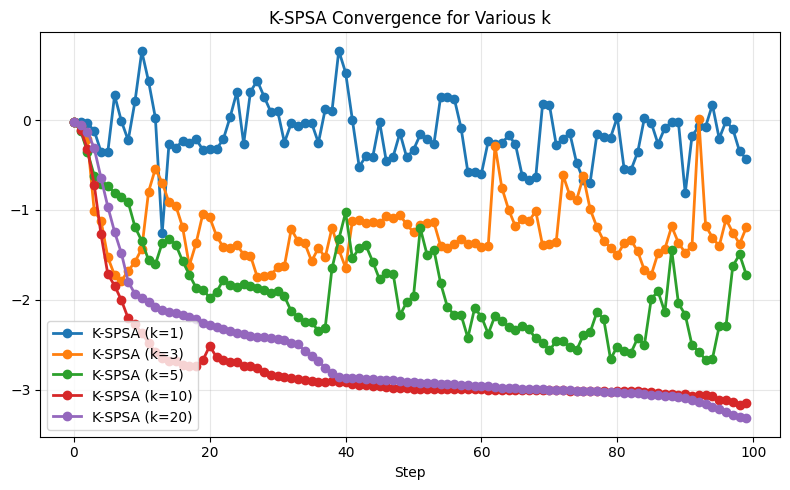

In [ ]:
# Convergence Comparison:
plt.figure(figsize=(8, 5))
for i, k in enumerate(k_samples):
    plt.plot(history_kspsa[i], marker='o', label=f'K-SPSA (k={k})', linewidth=2)


print('total parameters:', np.prod(temp.shape))
for i in range(len(t)):
    print(f"time for k={k_samples[i]}: {t[i]:.2f}s")
plt.xlabel('Step')
plt.title('K-SPSA Convergence for Various k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()